In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetV2B0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
import streamlit as st


In [5]:
!pip install streamlit 

In [6]:
# Paths to dataset
DATASET_DIR = "/kaggle/input/plantdisease/PlantVillage"  # Ensure this path contains the 15 category folders

# Load Data
def load_dataset(data_dir):
    categories = sorted(os.listdir(data_dir))
    data, labels = [], []
    for idx, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        for file in os.listdir(category_path):
            if file.endswith(('jpg', 'jpeg', 'png')):
                img = tf.keras.preprocessing.image.load_img(
                    os.path.join(category_path, file), target_size=(224, 224)
                )
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                data.append(img_array)
                labels.append(idx)
    return np.array(data), np.array(labels), categories

data, labels, category_names = load_dataset(DATASET_DIR)


Number of Samples: 156
Image Shape: (224, 224, 3)
Number of Categories: 15
0: Pepper__bell___Bacterial_spot
1: Pepper__bell___healthy
2: Potato___Early_blight
3: Potato___Late_blight
4: Potato___healthy
5: Tomato_Bacterial_spot
6: Tomato_Early_blight
7: Tomato_Late_blight
8: Tomato_Leaf_Mold
9: Tomato_Septoria_leaf_spot
10: Tomato_Spider_mites_Two_spotted_spider_mite
11: Tomato__Target_Spot
12: Tomato__Tomato_YellowLeaf__Curl_Virus
13: Tomato__Tomato_mosaic_virus
14: Tomato_healthy


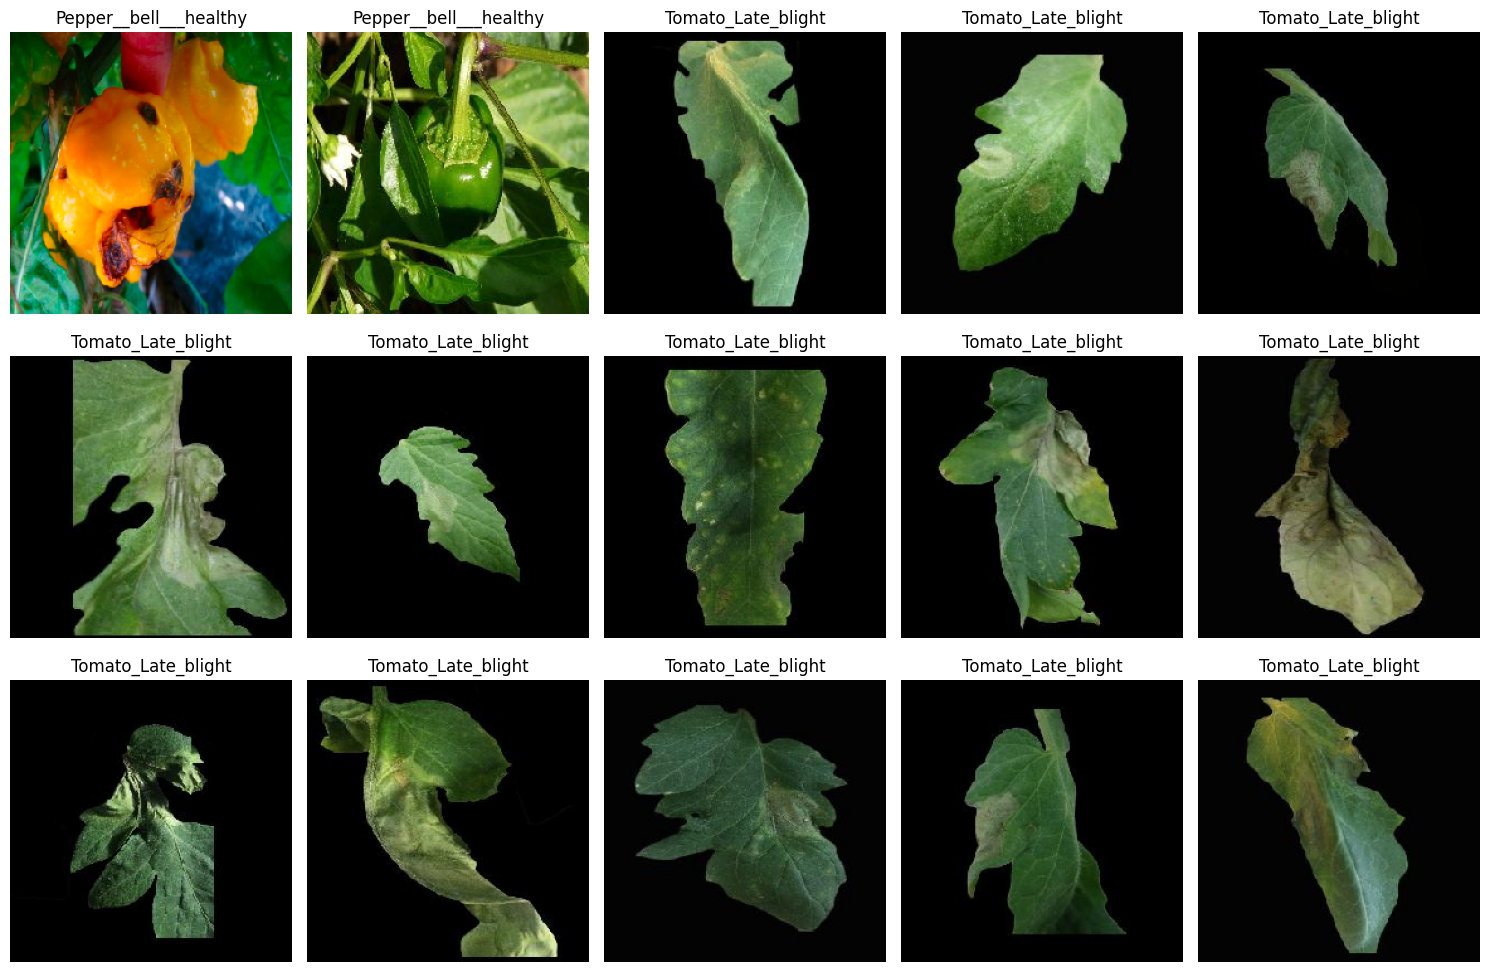

In [7]:
# Dataset Overview
print("Number of Samples:", data.shape[0])
print("Image Shape:", data.shape[1:])
print("Number of Categories:", len(category_names))
for i, category in enumerate(category_names):
    print(f"{i}: {category}")

# Plot Example Images
def plot_sample_images(data, labels, category_names):
    plt.figure(figsize=(15, 10))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(data[i].astype('uint8'))
        plt.title(category_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.savefig("sample_images.png", facecolor="white")

plot_sample_images(data, labels, category_names)


In [10]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

# Normalize
X_train, X_test = X_train / 255.0, X_test / 255.0


Train samples: 124
Test samples: 32


In [11]:
# Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = train_datagen.flow(X_train, y_train, batch_size=32)


In [12]:
def build_resnet50(num_classes):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

resnet_model = build_resnet50(len(category_names))
resnet_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:
def build_efficientnetv2(num_classes):
    base_model = EfficientNetV2B0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

efficientnet_model = build_efficientnetv2(len(category_names))
efficientnet_model.summary()


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ ?                      │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,858,704 (22.35 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [14]:
def build_cnn(num_classes):
    model = Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(128, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

cnn_model = build_cnn(len(category_names))
cnn_model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,895 (42.61 MB)

 Trainable params: 11,170,895 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Training ResNet50
history_resnet = resnet_model.fit(train_gen, epochs=10, validation_data=(X_test, y_test))

# Save Model
resnet_model.save("resnet_model.h5")

# Training EfficientNetV2
history_effnet = efficientnet_model.fit(train_gen, epochs=10, validation_data=(X_test, y_test))

# Save Model
efficientnet_model.save("efficientnet_model.h5")

# Training CNN
history_cnn = cnn_model.fit(train_gen, epochs=10, validation_data=(X_test, y_test))

# Save Model
cnn_model.save("cnn_model.h5")


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732248102.058020     155 service.cc:145] XLA service 0x7929e40020a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732248102.058110     155 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732248130.718563     155 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1732248130.771316     155 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the

4/4 ━━━━━━━━━━━━━━━━━━━━ 88s 10s/step - accuracy: 0.5279 - loss: 1.5381 - val_accuracy: 1.0000 - val_loss: 1.6618
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.9800 - loss: 0.1003 - val_accuracy: 1.0000 - val_loss: 0.0258
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.9816 - loss: 0.6562 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.9830 - loss: 0.1730 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.9655 - loss: 0.1319 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.9913 - loss: 0.0405 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.9883 - loss: 0.0471 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.9769 - loss: 0.0595 - val_accuracy: 1.0000 - v

I0000 00:00:1732248281.852219     155 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_13', 16 bytes spill stores, 16 bytes spill loads



4/4 ━━━━━━━━━━━━━━━━━━━━ 173s 23s/step - accuracy: 0.4277 - loss: 2.1572 - val_accuracy: 0.0000e+00 - val_loss: 3.3575
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9947 - loss: 0.3317 - val_accuracy: 0.0000e+00 - val_loss: 3.8154
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.9915 - loss: 0.0572 - val_accuracy: 0.0000e+00 - val_loss: 2.7034
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 1.0000 - loss: 0.0151 - val_accuracy: 1.0000 - val_loss: 1.3974
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 0.0095 - val_accuracy: 1.0000 - val_loss: 0.6375
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.9850 - loss: 0.0273 - val_accuracy: 1.0000 - val_loss: 0.6949
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9968 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 0.9252
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss

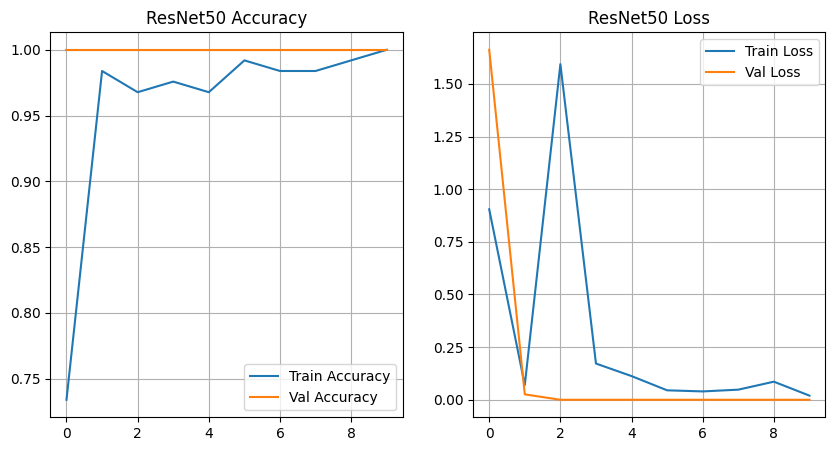

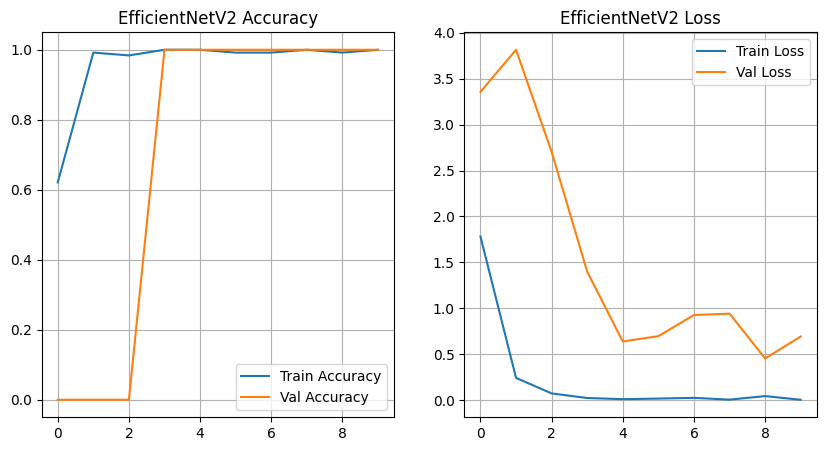

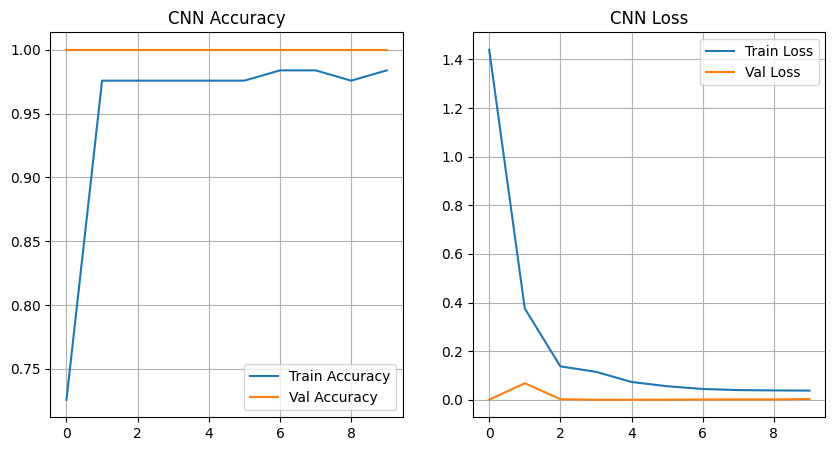

In [16]:
# Plot Function
def plot_metrics(history, model_name):
    plt.figure(figsize=(10, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()
    plt.grid()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    plt.grid()

    plt.savefig(f"{model_name}_metrics.png", facecolor="white")
    plt.show()

plot_metrics(history_resnet, "ResNet50")
plot_metrics(history_effnet, "EfficientNetV2")
plot_metrics(history_cnn, "CNN")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


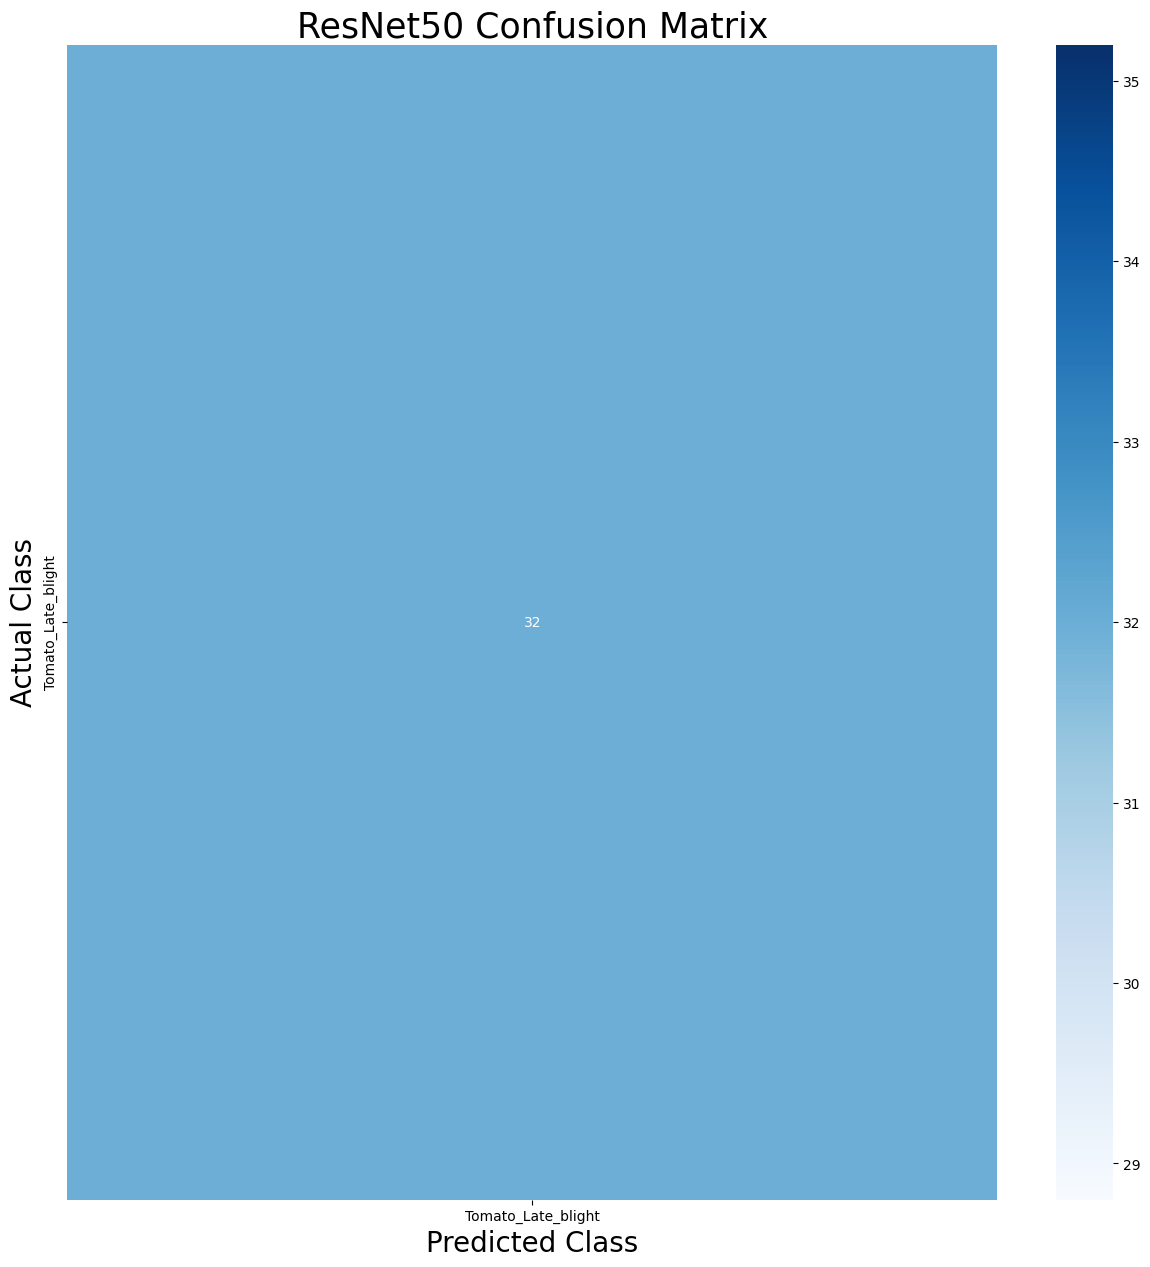

                    precision    recall  f1-score   support

Tomato_Late_blight       1.00      1.00      1.00        32

          accuracy                           1.00        32
         macro avg       1.00      1.00      1.00        32
      weighted avg       1.00      1.00      1.00        32

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


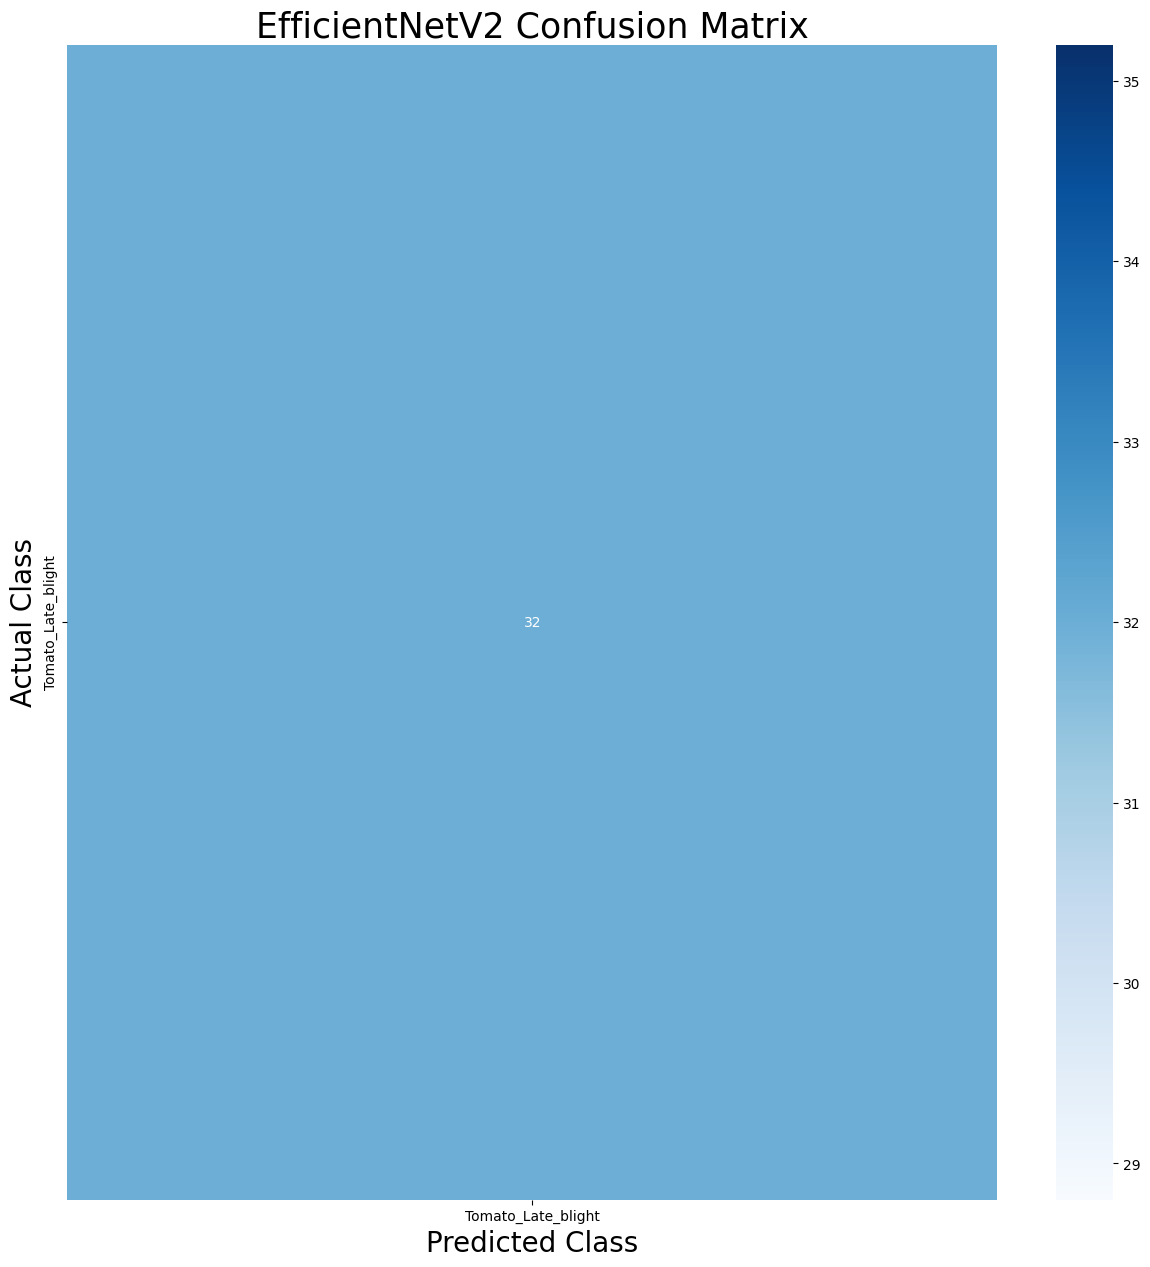

                    precision    recall  f1-score   support

Tomato_Late_blight       1.00      1.00      1.00        32

          accuracy                           1.00        32
         macro avg       1.00      1.00      1.00        32
      weighted avg       1.00      1.00      1.00        32

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


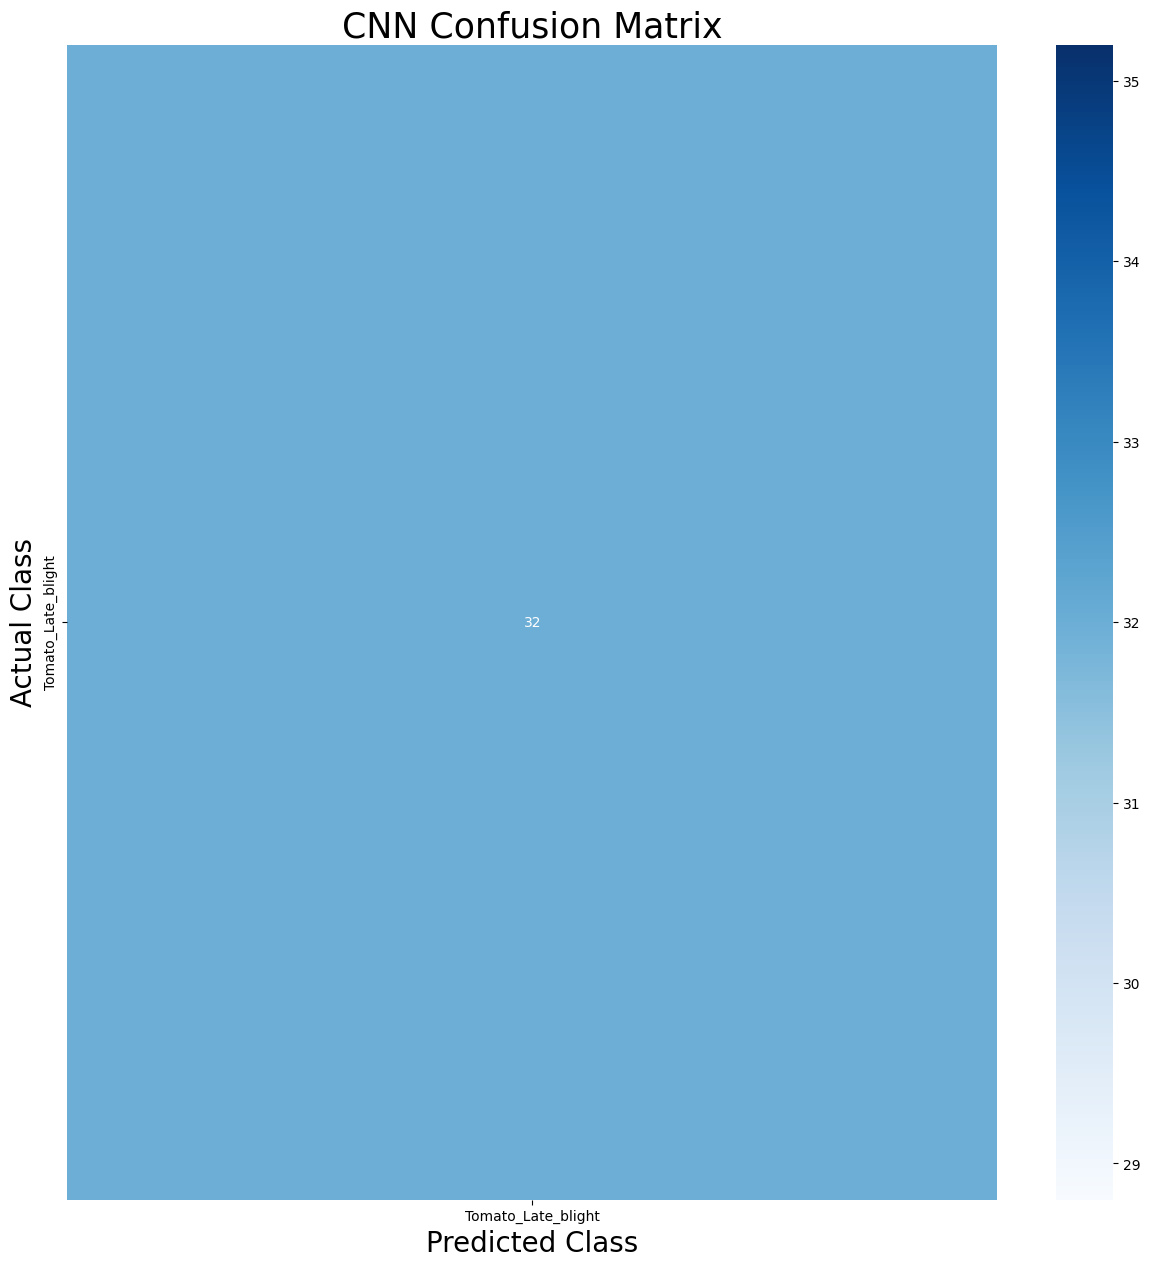

                    precision    recall  f1-score   support

Tomato_Late_blight       1.00      1.00      1.00        32

          accuracy                           1.00        32
         macro avg       1.00      1.00      1.00        32
      weighted avg       1.00      1.00      1.00        32



In [20]:
from sklearn.utils.multiclass import unique_labels

def evaluate_model(model, X_test, y_test, model_name):
    # Generate predictions
    predictions = np.argmax(model.predict(X_test), axis=1)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, predictions)
    
    # Dynamically identify the valid labels present in y_test and predictions
    valid_labels = unique_labels(y_test, predictions)
    valid_target_names = [category_names[i] for i in valid_labels]
    
    # Plot confusion matrix with custom styling
    plt.figure(figsize=(15, 15))  # Adjusted size
    sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        annot_kws={"size": 10}, 
        xticklabels=valid_target_names, 
        yticklabels=valid_target_names, 
        cmap="Blues"
    )
    
    plt.xlabel('Predicted Class', fontsize=20)
    plt.ylabel('Actual Class', fontsize=20)
    plt.title(f'{model_name} Confusion Matrix', fontsize=25)
    plt.gca().set_facecolor("blue")  # Set face color to blue
    plt.savefig(f"{model_name}_confusion_matrix.png", facecolor="blue", bbox_inches="tight")  # Save with blue background
    plt.show()

    # Generate classification report with valid labels
    print(classification_report(y_test, predictions, target_names=valid_target_names))

# Evaluate models
evaluate_model(resnet_model, X_test, y_test, "ResNet50")
evaluate_model(efficientnet_model, X_test, y_test, "EfficientNetV2")
evaluate_model(cnn_model, X_test, y_test, "CNN")

